##### import libs

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightfm
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

In [1]:
from utils import evaluate, load_data

In [2]:
from feature_processor import feedback_group_features

In [4]:
pd.set_option("display.max_rows", 100)

##### read data

In [7]:
user_item_data, user_meta_data, item_meta_data, test_pairs_data = load_data()

In [8]:
user_item_data = user_item_data.merge(
    right=item_meta_data.drop(columns="embeddings"),
    on="item_id",
    how="left",
)

In [7]:
test_pairs_data = test_pairs_data.merge(
    right=item_meta_data.drop(columns="embeddings"),
    on="item_id",
    how="left",
)

In [9]:
user_item_data = user_item_data.merge(
    right=user_meta_data,
    on="user_id",
    how="left",
)

In [9]:
test_pairs_data = test_pairs_data.merge(
    right=user_meta_data,
    on="user_id",
    how="left",
)

## group features

#### views and feedback grouped by user_id

In [10]:
user_group_features = feedback_group_features(
    user_item_data=user_item_data, group_col="user_id"
)

In [11]:
user_group_features.head(3)

,num_of_views_by_user_id,num_of_likes_by_user_id,ratio_of_likes_by_user_id,num_of_dislikes_by_user_id,ratio_of_dislikes_by_user_id,num_of_shares_by_user_id,ratio_of_shares_by_user_id,num_of_bookmarks_by_user_id,ratio_of_bookmarks_by_user_id
user_id,,,,,,,,,
0,368,25,0.067935,0,0.0,11,0.029891,0,0.0
1,203,13,0.064039,0,0.0,12,0.059113,0,0.0
2,127,6,0.047244,0,0.0,0,0.000000,0,0.0


In [12]:
user_item_data = user_item_data.merge(
    right=user_group_features,
    on="user_id",
    how="left",
)

In [13]:
test_pairs_data = test_pairs_data.merge(
    right=user_group_features,
    on="user_id",
    how="left",
)

#### views and feedback grouped by item_id

In [14]:
item_group_features = feedback_group_features(
    user_item_data=user_item_data, group_col="item_id"
)

In [15]:
item_group_features.head(3)

,num_of_views_by_item_id,num_of_likes_by_item_id,ratio_of_likes_by_item_id,num_of_dislikes_by_item_id,ratio_of_dislikes_by_item_id,num_of_shares_by_item_id,ratio_of_shares_by_item_id,num_of_bookmarks_by_item_id,ratio_of_bookmarks_by_item_id
item_id,,,,,,,,,
0,51,3,0.058824,0,0.0,5,0.098039,0,0.0
1,43,3,0.069767,0,0.0,3,0.069767,0,0.0
2,63,5,0.079365,0,0.0,4,0.063492,0,0.0


In [16]:
user_item_data = user_item_data.merge(
    right=item_group_features,
    on="item_id",
    how="left",
)

In [17]:
test_pairs_data = test_pairs_data.merge(
    right=item_group_features,
    on="item_id",
    how="left",
)

#### views and feedback grouped by source_id

In [18]:
source_group_features = feedback_group_features(
    user_item_data=user_item_data, group_col="source_id"
)

In [19]:
source_group_features.head(3)

,num_of_views_by_source_id,num_of_likes_by_source_id,ratio_of_likes_by_source_id,num_of_dislikes_by_source_id,ratio_of_dislikes_by_source_id,num_of_shares_by_source_id,ratio_of_shares_by_source_id,num_of_bookmarks_by_source_id,ratio_of_bookmarks_by_source_id
source_id,,,,,,,,,
0,2063,9,0.004363,3,0.001454,3,0.001454,0,0.000000
1,178,7,0.039326,0,0.000000,10,0.056180,1,0.005618
2,46,1,0.021739,0,0.000000,1,0.021739,0,0.000000


In [20]:
user_item_data = user_item_data.merge(
    right=source_group_features,
    on="source_id",
    how="left",
)

In [21]:
test_pairs_data = test_pairs_data.merge(
    right=source_group_features,
    on="source_id",
    how="left",
)

#### item_id average gender and age

In [22]:
viewers_statistics_by_item_id = user_item_data.groupby("item_id").agg(
    min_viewers_age_by_item_id=pd.NamedAgg(column="age", aggfunc="min"),
    max_viewers_age_by_item_id=pd.NamedAgg(column="age", aggfunc="max"),
    mean_viewers_age_by_item_id=pd.NamedAgg(column="age", aggfunc="mean"),
    median_viewers_age_by_item_id=pd.NamedAgg(column="age", aggfunc="median"),
    std_viewers_age_by_item_id=pd.NamedAgg(column="age", aggfunc="std"),
    min_viewers_gender_by_item_id=pd.NamedAgg(column="gender", aggfunc="min"),
    max_viewers_gender_by_item_id=pd.NamedAgg(column="gender", aggfunc="max"),
    mean_viewers_gender_by_item_id=pd.NamedAgg(column="gender", aggfunc="mean"),
    median_viewers_gender_by_item_id=pd.NamedAgg(column="gender", aggfunc="median"),
    std_viewers_gender_by_item_id=pd.NamedAgg(column="gender", aggfunc="std"),
)


In [23]:
viewers_statistics_by_item_id = viewers_statistics_by_item_id.astype(
    {
        col_name: (np.float32 if dtype == np.float64 else dtype)
        for col_name, dtype in viewers_statistics_by_item_id.dtypes.to_dict().items()
    }
)

In [24]:
likers_statistics_by_item_id = (
    user_item_data[user_item_data.like == 1]
    .groupby("item_id")
    .agg(
        min_likers_age_by_item_id=pd.NamedAgg(column="age", aggfunc="min"),
        max_likers_age_by_item_id=pd.NamedAgg(column="age", aggfunc="max"),
        mean_likerss_age_by_item_id=pd.NamedAgg(column="age", aggfunc="mean"),
        median_likers_age_by_item_id=pd.NamedAgg(column="age", aggfunc="median"),
        std_likers_age_by_item_id=pd.NamedAgg(column="age", aggfunc="std"),
        min_likers_gender_by_item_id=pd.NamedAgg(column="gender", aggfunc="min"),
        max_likers_gender_by_item_id=pd.NamedAgg(column="gender", aggfunc="max"),
        mean_likers_gender_by_item_id=pd.NamedAgg(column="gender", aggfunc="mean"),
        median_likers_gender_by_item_id=pd.NamedAgg(column="gender", aggfunc="median"),
        std_likers_gender_by_item_id=pd.NamedAgg(column="gender", aggfunc="std"),
    )
)

In [25]:
likers_statistics_by_item_id = likers_statistics_by_item_id.astype(
    {
        col_name: (np.float32 if dtype == np.float64 else dtype)
        for col_name, dtype in likers_statistics_by_item_id.dtypes.to_dict().items()
    }
)

In [26]:
user_item_data = user_item_data.merge(
    right=viewers_statistics_by_item_id,
    on="item_id",
    how="left",
)

: 

In [ ]:
test_pairs_data = test_pairs_data.merge(
    right=viewers_statistics_by_item_id,
    on="item_id",
    how="left",
)

#### source_id-specific views and feedback grouped by user_id

In [ ]:
user_view_counts_by_source_id = user_item_data.groupby(by="user_id").source_id.apply(
    lambda x: x.value_counts()
)
user_like_counts_by_source_id = (
    user_item_data[user_item_data.like == 1]
    .groupby(by="user_id")
    .source_id.apply(lambda x: x.value_counts())
)

user_view_counts_by_source_id

In [ ]:
user_view_counts_by_source_id_dict = user_view_counts_by_source_id.to_dict()

user_item_data["user_view_counts_by_source_id"] = [
    user_view_counts_by_source_id_dict.get((user_id, source_id), 0)
    for user_id, source_id in zip(
        user_item_data["user_id"], user_item_data["source_id"]
    )
]

In [ ]:
test_pairs_data["user_view_counts_by_source_id"] = [
    user_view_counts_by_source_id_dict.get((user_id, source_id), 0)
    for user_id, source_id in zip(
        test_pairs_data["user_id"], test_pairs_data["source_id"]
    )
]

In [ ]:
user_like_counts_by_source_id_dict = user_like_counts_by_source_id.to_dict()

In [ ]:
user_item_data["user_like_counts_by_source_id"] = [
    user_like_counts_by_source_id_dict.get((user_id, source_id), 0)
    for user_id, source_id in zip(
        user_item_data["user_id"], user_item_data["source_id"]
    )
]

In [ ]:
test_pairs_data["user_like_counts_by_source_id"] = [
    user_like_counts_by_source_id_dict.get((user_id, source_id), 0)
    for user_id, source_id in zip(
        test_pairs_data["user_id"], test_pairs_data["source_id"]
    )
]

In [ ]:
user_item_data.user_like_counts_by_source_id = (
    user_item_data.user_like_counts_by_source_id - user_item_data.like
)
user_item_data.user_view_counts_by_source_id = (
    user_item_data.user_view_counts_by_source_id - 1
)

In [ ]:
test_pairs_data.user_like_counts_by_source_id = (
    test_pairs_data.user_like_counts_by_source_id
)
test_pairs_data.user_view_counts_by_source_id = (
    test_pairs_data.user_view_counts_by_source_id
)

In [ ]:
user_item_data["user_view_counts_by_source_id_ratio_to_views"] = (
    user_item_data["user_view_counts_by_source_id"]
    / user_item_data["num_of_views_by_user_id"]
)
user_item_data["user_like_counts_by_source_id_ratio_to_views"] = (
    user_item_data["user_like_counts_by_source_id"]
    / user_item_data["user_view_counts_by_source_id"]
)
user_item_data["user_like_counts_by_source_id_ratio_to_likes"] = (
    user_item_data["user_like_counts_by_source_id"]
    / user_item_data["num_of_likes_by_user_id"]
)

user_item_data["user_view_counts_by_source_id_ratio_to_views"] = user_item_data[
    "user_view_counts_by_source_id_ratio_to_views"
].fillna(0)
user_item_data["user_like_counts_by_source_id_ratio_to_views"] = user_item_data[
    "user_like_counts_by_source_id_ratio_to_views"
].fillna(0)
user_item_data["user_like_counts_by_source_id_ratio_to_likes"] = user_item_data[
    "user_like_counts_by_source_id_ratio_to_likes"
].fillna(0)

In [ ]:
test_pairs_data["user_view_counts_by_source_id_ratio_to_views"] = (
    test_pairs_data["user_view_counts_by_source_id"]
    / test_pairs_data["num_of_views_by_user_id"]
)
test_pairs_data["user_like_counts_by_source_id_ratio_to_views"] = (
    test_pairs_data["user_like_counts_by_source_id"]
    / test_pairs_data["user_view_counts_by_source_id"]
)
test_pairs_data["user_like_counts_by_source_id_ratio_to_likes"] = (
    test_pairs_data["user_like_counts_by_source_id"]
    / test_pairs_data["num_of_likes_by_user_id"]
)

test_pairs_data["user_view_counts_by_source_id_ratio_to_views"] = test_pairs_data[
    "user_view_counts_by_source_id_ratio_to_views"
].fillna(0)
test_pairs_data["user_like_counts_by_source_id_ratio_to_views"] = test_pairs_data[
    "user_like_counts_by_source_id_ratio_to_views"
].fillna(0)
test_pairs_data["user_like_counts_by_source_id_ratio_to_likes"] = test_pairs_data[
    "user_like_counts_by_source_id_ratio_to_likes"
].fillna(0)

In [ ]:
user_item_data = user_item_data.astype(
    {
        "user_like_counts_by_source_id": np.int16,
        "user_view_counts_by_source_id": np.int16,
        "user_view_counts_by_source_id_ratio_to_views": np.float32,
        "user_like_counts_by_source_id_ratio_to_views": np.float32,
        "user_like_counts_by_source_id_ratio_to_likes": np.float32,
    }
)

In [ ]:
test_pairs_data = test_pairs_data.astype(
    {
        "user_like_counts_by_source_id": np.int16,
        "user_view_counts_by_source_id": np.int16,
        "user_view_counts_by_source_id_ratio_to_views": np.float32,
        "user_like_counts_by_source_id_ratio_to_views": np.float32,
        "user_like_counts_by_source_id_ratio_to_likes": np.float32,
    }
)

In [ ]:
user_item_data.head(3)

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit,source_id,duration,...,min_viewers_gender_by_item_id,max_viewers_gender_by_item_id,mean_viewers_gender_by_item_id,median_viewers_gender_by_item_id,std_viewers_gender_by_item_id,user_view_counts_by_source_id,user_like_counts_by_source_id,user_view_counts_by_source_id_ratio_to_views,user_like_counts_by_source_id_ratio_to_views,user_like_counts_by_source_id_ratio_to_likes
0,3810,138979,6,0,0,0,0,0,4278,54,...,1,2,1.055644,1.0,0.229415,17,0,0.007185,0.0,0.0
1,101874,331160,6,0,0,0,0,0,2049,6,...,2,2,2.000000,2.0,0.000000,0,0,0.000000,0.0,0.0
2,150332,73709,11,0,0,0,0,0,16375,16,...,1,2,1.395858,1.0,0.489070,0,0,0.000000,0.0,0.0


In [ ]:
test_pairs_data.head(3)

,user_id,item_id,source_id,duration,gender,age,num_of_views_by_user_id,num_of_likes_by_user_id,ratio_of_likes_by_user_id,num_of_dislikes_by_user_id,...,min_viewers_gender_by_item_id,max_viewers_gender_by_item_id,mean_viewers_gender_by_item_id,median_viewers_gender_by_item_id,std_viewers_gender_by_item_id,user_view_counts_by_source_id,user_like_counts_by_source_id,user_view_counts_by_source_id_ratio_to_views,user_like_counts_by_source_id_ratio_to_views,user_like_counts_by_source_id_ratio_to_likes
0,1,7363,5119,9,2,35,203,13,0.064039,0,...,1,2,1.720927,2.0,0.448558,0,0,0.0,0.0,0.0
1,1,73770,2720,5,2,35,203,13,0.064039,0,...,1,2,1.830077,2.0,0.375596,0,0,0.0,0.0,0.0
2,1,75700,11601,32,2,35,203,13,0.064039,0,...,1,2,1.988804,2.0,0.105236,0,0,0.0,0.0,0.0


#### dump

In [66]:
user_item_data.to_parquet("data/user_item_data_w_group_features.parquet")

In [67]:
test_pairs_data.to_parquet("data/test_pairs_data_w_group_features.parquet")

## lag features

In [ ]:
def compute_rolling_features(
    train_df, val_df, group_col, target_col, lags, windows, agg_funcs
):
    """
    Computes rolling lag, window and expanding window features for a target column within groups of a specified column.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        group_col (str): Column name to group by.
        target_col (str): Column name for which lagged features are computed.
        lags (list): List of lag steps to compute.
        windows (list): List of window sizes to compute.
        agg_funcs (list): List of functions to be used for aggregation.

    Returns:
        pd.DataFrame: DataFrame with additional rolling features.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    train_df = train_df.copy()

    # Group by the specified column and apply shifting for each lag
    grouped = train_df.groupby(group_col, as_index=False)
    for lag in tqdm(lags):
        train_df[f"{target_col}_lag_{lag}"] = (
            grouped[target_col].shift(lag).fillna(0).astype(np.int8)
        )

    for window in tqdm(windows):
        for agg_func in agg_funcs:
            train_df[f"{target_col}_window_{window}_agg_{agg_func}"] = (
                grouped[target_col]
                .rolling(window=window, min_periods=0)
                .agg(agg_func)
                .like.astype(np.int16)
            )

    return train_df

In [ ]:
def compute_lag(
    train_df,
    val_df,
    group_col,
    target_col,
    lag,
):
    grouped = train_df.groupby(group_col, as_index=False)
    lag_col_name = f"{target_col}_lag_{lag}"
    train_df[lag_col_name] = grouped[target_col].shift(lag).fillna(0).astype(np.int16)
    grouped = train_df.groupby(group_col, as_index=False)
    last_lag_by_user_id = grouped[lag_col_name].agg("last")
    val_df = val_df.merge(right=last_lag_by_user_id, on=group_col, how="left")
    return train_df, val_df

In [11]:
grouped = user_item_data.groupby("item_id", as_index=False)

In [12]:
user_item_data["like_lag_1"] = grouped["like"].shift(1).fillna(0).astype(np.int16)
grouped = user_item_data.groupby("item_id", as_index=False)

In [18]:
last_like_lag_1_by_item_id = grouped.like_lag_1.agg("last")

In [19]:
train_df, val_df = train_test_split(
    user_item_data,
    test_size=0.15,
    random_state=42,
    shuffle=False,
)

In [ ]:
val_df = val_df.drop(columns=["like_lag_1"]).merge(
    right=last_like_lag_1_by_item_id, on="item_id", how="left"
)

In [16]:
train_df.corr()

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit,source_id,duration,like_lag_1
user_id,1.000000,0.001844,-0.041510,0.040867,-0.001346,0.002052,0.007363,0.040796,-0.025984,-0.053056,0.025746
item_id,0.001844,1.000000,-0.005022,0.000779,-0.000024,0.000840,-0.000008,0.000777,-0.027197,-0.010569,0.000806
timespent,-0.041510,-0.005022,1.000000,0.043284,0.005536,0.067186,0.021156,0.042557,-0.042672,0.455320,-0.053048
like,0.040867,0.000779,0.043284,1.000000,-0.004356,0.133063,0.064381,0.995601,-0.023153,-0.099247,0.068401
dislike,-0.001346,-0.000024,0.005536,-0.004356,1.000000,-0.000258,0.003142,-0.098034,-0.001080,0.004964,-0.001165
share,0.002052,0.000840,0.067186,0.133063,-0.000258,1.000000,0.034109,0.132447,-0.006732,-0.029074,0.015873
bookmarks,0.007363,-0.000008,0.021156,0.064381,0.003142,0.034109,1.000000,0.063777,-0.004460,-0.006969,0.005884
explicit,0.040796,0.000777,0.042557,0.995601,-0.098034,0.132447,0.063777,1.000000,-0.022940,-0.099235,0.068182
source_id,-0.025984,-0.027197,-0.042672,-0.023153,-0.001080,-0.006732,-0.004460,-0.022940,1.000000,-0.081364,-0.023012
duration,-0.053056,-0.010569,0.455320,-0.099247,0.004964,-0.029074,-0.006969,-0.099235,-0.081364,1.000000,-0.099024


In [17]:
val_df.corr()

,user_id,item_id,timespent,like,dislike,share,bookmarks,explicit,source_id,duration,like_lag_1
user_id,1.000000,-0.000095,-0.042766,0.039810,-0.001179,0.000520,0.008495,0.039730,-0.017532,-0.054019,0.023559
item_id,-0.000095,1.000000,-0.005194,0.001415,0.000180,0.001174,-0.000414,0.001391,-0.032853,-0.008615,-0.006328
timespent,-0.042766,-0.005194,1.000000,0.039160,0.006221,0.064452,0.020738,0.038395,-0.039010,0.476016,-0.053279
like,0.039810,0.001415,0.039160,1.000000,-0.004547,0.127442,0.069273,0.995664,-0.013772,-0.101154,0.077742
dislike,-0.001179,0.000180,0.006221,-0.004547,1.000000,-0.000566,0.004025,-0.097547,-0.001416,0.005162,-0.001319
share,0.000520,0.001174,0.064452,0.127442,-0.000566,1.000000,0.036677,0.126888,-0.005036,-0.032644,0.014867
bookmarks,0.008495,-0.000414,0.020738,0.069273,0.004025,0.036677,1.000000,0.068569,-0.003483,-0.007879,0.006917
explicit,0.039730,0.001391,0.038395,0.995664,-0.097547,0.126888,0.068569,1.000000,-0.013575,-0.101153,0.077494
source_id,-0.017532,-0.032853,-0.039010,-0.013772,-0.001416,-0.005036,-0.003483,-0.013575,1.000000,-0.075253,-0.026433
duration,-0.054019,-0.008615,0.476016,-0.101154,0.005162,-0.032644,-0.007879,-0.101153,-0.075253,1.000000,-0.099942


# global time features

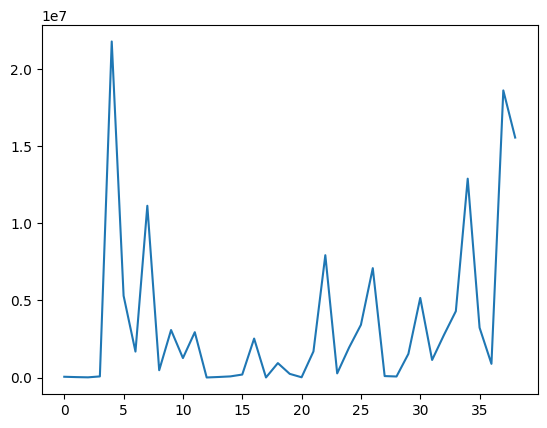

: 

In [ ]:
user_views = user_item_data[
    (user_item_data["user_id"] == 120983) & (user_item_data["like"] == 1)
].index.values
plt.plot(np.diff(user_views))